In [1]:
from pathlib import Path
import os

In [15]:
dataroot = Path("/mnt/h/saranathan_share/rush")
folders = [Path(item.path) for item in os.scandir(dataroot)]

images = [folder/"left/crop_T1w_acpc_dc_restore_brain.nii.gz" for folder in folders]

images = []
for folder in folders:
    file = list((folder / "left").glob("*.nii.gz"))[0]
    if not file.is_file():
        raise FileNotFoundError(str(file))
    images.append(file)

In [16]:
with open("filelist.txt", 'w') as f:
    for im in images:
        f.write(str(im)+"\n")

In [98]:
import tensorflow as tf
import statistics

In [3]:
event_file_path = "/home/srs-9/Projects/ms_mri/training_work_dirs/choroid_pineal_pituitary_T1-1/swinunetr_0/model_fold0/Events/events.out.tfevents.1736894788.ryzen9.3061389.0"
events = []
for event in tf.compat.v1.train.summary_iterator(event_file_path):
    events.append(event)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
i = 0

In [18]:
event = events[i]
i += 1
event

wall_time: 1736894798.0335381
step: 3
summary {
  value {
    tag: "train/loss"
    simple_value: 2.57765532
  }
}

In [20]:
hasattr(event, "step")

True

In [114]:
steps_per_epoch = 12
n_epochs = 70
train_losses = [[] for i in range(n_epochs)]
val_metrics = [[] for i in range(n_epochs)]
for event in events:
    next_event = False
    for val in event.summary.value:
        if val.tag == "train/loss":
            step = event.step
            epoch = (step-1) // (steps_per_epoch)
            train_losses[epoch].append(val.simple_value)   
        elif val.tag == "val/acc":
            epoch = event.step - 1
            val_metrics[epoch].append(val.simple_value)

In [142]:
import numpy as np

N = 3

x_loss = []
y_loss = []
for i, losses in enumerate(train_losses):
    x_loss.append(i)
    y_loss.append(statistics.mean(losses))
x_loss = np.array(x_loss)
y_loss = np.array(y_loss)
y_loss_mov = np.convolve(y_loss, np.ones(N)/N, mode='valid')
x_loss_mov = x_loss[1:-1]

x_metric = []
y_metric = []
for i, metrics in enumerate(val_metrics):
    if len(metrics) > 0:
        x_metric.append(i)
        y_metric.append(statistics.mean(metrics))

x_metric = np.array(x_metric)
y_metric = np.array(y_metric)
# y_metric_mov = np.convolve()

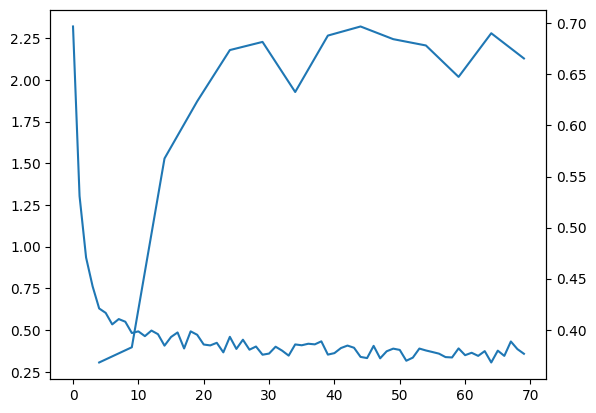

In [144]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(x_loss, y_loss)
ax2 = ax1.twinx()
ax2.plot(x_metric, y_metric)

In [121]:
steps = []
for event in events:
    if hasattr(event, "step"):
        steps.append(event.step)

In [110]:
event.summary.value[-1]

tag: "val/acc"
simple_value: 0.665616333

In [111]:
check = events[-1]
check

wall_time: 1736895901.27822
step: 70
summary {
  value {
    tag: "val/acc"
    simple_value: 0.665616333
  }
}

In [13]:
event.WhichOneof('what')

'summary'

In [1]:
from reload_recursive import reload_recursive
import mri_data
import monai_training
import subprocess

In [2]:
from pathlib import Path
reload_recursive(mri_data)
reload_recursive(monai_training)
from mri_data import file_manager as fm
from mri_data import utils
from monai_training import preprocess
from loguru import logger
import pyperclip

In [3]:
import os
from pathlib import Path
import numpy as np
import json
from loguru import logger
import platform

import mri_data
import monai_training

from monai.apps.auto3dseg import (
    AlgoEnsembleBestN,
    AlgoEnsembleBuilder,
    import_bundle_algo_history,
)
from monai.utils.enums import AlgoKeys

from reload_recursive import reload_recursive

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
2025-03-21 12:43:45.605190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 12:43:45.826054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742575425.904743   35705 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alre

In [25]:
work_dir = Path("/mnt/h/srs-9/training_work_dirs/choroid_pineal_pituitary_T1-1")
files = [{"image": "/mnt/h/3Tpioneer_bids/sub-ms1002/ses-20200521/t1_gd.nii.gz"}]
save_dir = Path("/mnt/h/srs-9/3Tpioneer_bids_predictions")
prediction_postfix = "t1_gd_test"

task = {
    "name": "test",
    "task": "infer",
    "modality": "MRI",
    "datalist": files,
    "dataroot": str(dataroot)
}

task_file = "test.json"
with open(task_file, 'w') as f:
    json.dump(task, f, indent=4)

In [26]:
input_cfg = task_file  # path to the task input YAML file created by the users

history = import_bundle_algo_history(work_dir, only_trained=True)

In [27]:
## model ensemble
n_best = 5
builder = AlgoEnsembleBuilder(history, input_cfg)
builder.set_ensemble_method(AlgoEnsembleBestN(n_best=n_best))
ensemble = builder.get_ensemble()
save_params = {
    "_target_": "SaveImage",
    "output_dir": save_dir,
    "data_root_dir": dataroot,
    "output_postfix": prediction_postfix,
    "separate_folder": False,
}

pred = ensemble(pred_param={"image_save_func": save_params})

Ensembling (rank 0)...:   0%|          | 0/1 [00:00<?, ?it/s]monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `we

2025-03-03 19:41:12,391 INFO image_writer.py:197 - writing: /mnt/h/srs-9/3Tpioneer_bids_predictions/sub-ms1002/ses-20200521/t1_gd_t1_gd_test.nii.gz


Image save path not returned.
Ensembling (rank 0)...: 100%|██████████| 1/1 [02:57<00:00, 177.49s/it]


In [28]:
history

[{identifier: 'swinunetr_0',
  algo_instance: <swinunetr.scripts.algo.SwinunetrAlgo at 0x7ff4195a3c80>,
  best_metric: 0.7079485522376167,
  is_trained: True},
 {identifier: 'swinunetr_1',
  algo_instance: <swinunetr.scripts.algo.SwinunetrAlgo at 0x7ff417bb5910>,
  best_metric: 0.6904570526546902,
  is_trained: True},
 {identifier: 'swinunetr_2',
  algo_instance: <swinunetr.scripts.algo.SwinunetrAlgo at 0x7ff417ba84d0>,
  best_metric: 0.7012612289852567,
  is_trained: True},
 {identifier: 'swinunetr_3',
  algo_instance: <swinunetr.scripts.algo.SwinunetrAlgo at 0x7ff417bc2e10>,
  best_metric: 0.6825764841503568,
  is_trained: True},
 {identifier: 'swinunetr_4',
  algo_instance: <swinunetr.scripts.algo.SwinunetrAlgo at 0x7ff417bc20c0>,
  best_metric: 0.7142895857493082,
  is_trained: True}]

In [29]:
history[0]["algo_instance"].get_inferer

In [8]:
dataset_full = preprocess.DataSetProcesser.new_dataset(dataroot, fm.scan_3Tpioneer_bids, filters=[fm.filter_first_ses]).dataset
dataset_full.sort()
labeled = dict(subjects=[scan.subid for scan in dataset_full])

In [9]:
from collections import defaultdict
itksnap_commands = {}
for scan in dataset_full:
    images = [scan.root/"flair.nii.gz", scan.root/"t1.nii.gz"]
    itksnap_commands[scan.subid] = utils.open_itksnap_workspace_cmd(images, win=False)

In [31]:
cmd = itksnap_commands['1281']
print(cmd)
subprocess.Popen(cmd.split(' '))

itksnap -g /media/smbshare/3Tpioneer_bids/sub-ms1281/ses-20180705/flair.nii.gz -o /media/smbshare/3Tpioneer_bids/sub-ms1281/ses-20180705/t1.nii.gz


<Popen: returncode: None args: ['itksnap', '-g', '/media/smbshare/3Tpioneer_...>

Launching ITK-SNAP


Return code : 0


In [20]:
dataset_proc = preprocess.DataSetProcesser.new_dataset(dataroot, fm.scan_3Tpioneer_bids, filters=[fm.filter_first_ses])
dataset_proc.prepare_labels("pituitary", suffix_list=["CH", "ED", "DT"])
pituitary_subs = [scan.subid for scan in dataset_proc.dataset]

100%|██████████| 575/575 [00:04<00:00, 135.34it/s]


In [23]:
dataset_proc = preprocess.DataSetProcesser.new_dataset(dataroot, fm.scan_3Tpioneer_bids, filters=[fm.filter_first_ses])
dataset_proc.prepare_labels("pineal", suffix_list=["CH", "SRS"])
pineal_subs = [scan.subid for scan in dataset_proc.dataset]

100%|██████████| 575/575 [00:04<00:00, 122.89it/s]


In [24]:
dataset_proc = preprocess.DataSetProcesser.new_dataset(dataroot, fm.scan_3Tpioneer_bids, filters=[fm.filter_first_ses])
dataset_proc.prepare_labels("choroid_t1_flair", suffix_list=["CH", "ED", "DT"])
choroid_subs = [scan.subid for scan in dataset_proc.dataset]

100%|██████████| 575/575 [00:04<00:00, 121.05it/s]


In [41]:
labeled['pituitary'] = [True if scan.subid in pituitary_subs else "" for scan in dataset_full]
labeled['pineal'] = [True if scan.subid in pineal_subs else "" for scan in dataset_full]
labeled['choroid'] = [True if scan.subid in choroid_subs else "" for scan in dataset_full]

In [42]:
import csv

with open("labeled_subjects.csv", 'w') as f:
    writer = csv.DictWriter(f, labeled.keys())
    writer.writeheader()
    for i in range(len(labeled['subjects'])):
        writer.writerow({k: labeled[k][i] for k in labeled})